In [1]:
%matplotlib inline

from modsim import *

In [2]:
r_tea = 0.00019348499840078214 #I calculated this using the code from notebook 7, this is a factor that allows us 
                                  # to use 1 second increments instead of 1 minute increments 
                                  # times should be multiplied by 60 to get actual time in seconds
init = State(temp=90, steeping = 0)
tea = System(init=init, volume=300, 
             r = 0.012, s_inf=1.01,
                T_env=22,
                t0=0, 
                t_end=30,
                dt=1)

In [3]:
def update(state, system):
    """Update the thermal transfer and steeping factor
    
    state: State (temp, steeping)
    system: System object
    
    returns: State (temp, steeping)
    """
    unpack(system)
    T = state.temp
    T += -r * (T - T_env) * dt
    
    sf = state.steeping
    dsfdt = exp(-1/T)*(sf - s_inf)**2
    sf += dsfdt*dt

    return State(temp=T, steeping = sf)

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], system)
    
    system.results = frame

In [5]:
run_simulation(tea, update)


In [6]:
def make_system(T_init=90, r=0.01, s_inf = 1.01, volume=300, t_end=30, s_init = 0):
    """Makes a system with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(temp=T_init, steeping = s_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    s_inf = s_inf,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

In [7]:
def final_steeping(system):
    """Final steeping factor.
    
    If system has no results, return initial steeping factor.
    
    system: System object.
    
    returns: steeping factor (arbitrary units)
    """    
    if hasattr(system, 'results'):
        return system.results.steeping[system.t_end]
    else:
        return system.init.steeping
    
def error_func(s_inf):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r = r_tea, s_inf = s_inf, volume=300, t_end=60*1) #Change t_end to determine how long the
                                                            #tea takes to get to a certain percent of s_inf
    run_simulation(system, update)
    return final_steeping(system) - s_inf * 0.5            #this number is the percent of s_sinf the system reaches by 8 minutes

In [8]:
def final_temp(system):
    """Final temperature.
    
    If system has no results, return initial temp.
    
    system: System object.
    
    returns: temperature (degC)
    """    
    if hasattr(system, 'results'):
        return system.results.temp[system.t_end]
    else:
        return system.init.temp

In [9]:

system = make_system(T_init=90, r = r_tea, s_inf = .05, volume=300, t_end=240)
run_simulation(system, update)
#plot(system.results.steeping)

In [10]:
solution = fsolve(error_func, 1) #usinf fsolve to find the steeping factor at infinity assuming full brewing at 8 minutes
s_inf_tea = solution[0]
s_inf_tea


0.016660092207575108

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


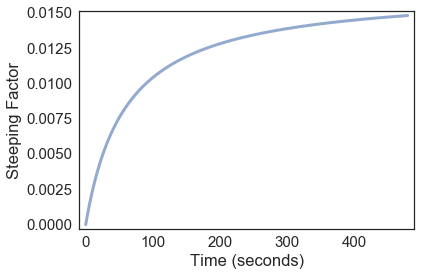

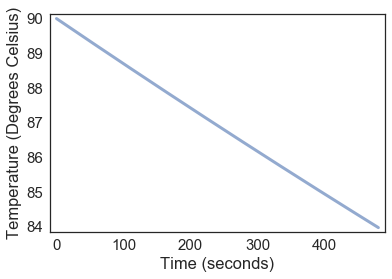

In [11]:
system = make_system(T_init=90, r = r_tea, s_inf = s_inf_tea, volume=300, t_end=60*8)
run_simulation(system, update)
plot(system.results.steeping)
decorate(xlabel='Time (seconds)',
         ylabel='Steeping Factor',
         loc='center left')
newfig()
plot(system.results.temp)
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (Degrees Celsius)',
         loc='center left')

In [12]:
error_func(1)

0.49330344173399943

In [13]:
#tea = make_system(T_init=90, r = r_tea, s_inf = 1.01, volume=300, t_end=240)
update(tea.init, tea)

,value
temp,89.184000
steeping,1.008726


In [14]:
exp(-1/90)*(0 - 0.05)**2

0.0024723759732348063

In [15]:
def mix(tea, milk):
    """Simulates the mixture of two liquids.
    
    s1: System representing TEA
    s2: System representing milk
    
    returns: System representing the mixture
    """
    assert tea.t_end == milk.t_end
    
    volume = tea.volume + milk.volume
    
    temp = (tea.volume * final_temp(tea) + 
            milk.volume * final_temp(milk)) / volume
    
    steeping = ((final_steeping(tea)*tea.volume)/volume)
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=tea.r,
                          s_init=steeping,
                          s_inf = s_inf_tea)
    
    return mixture

In [16]:
tea = make_system(T_init=90, r = r_tea, s_inf = 1.01, volume=300, t_end=240)
milk = make_system(T_init=5, r = r_tea, s_inf = s_inf, volume=30, t_end=240)
mix(tea, milk)

,value
init,temp 82.272727 steeping 0.000000 dt...
volume,330
r,0.000193485
s_inf,0.0166601
T_env,22
t0,0
t_end,30
dt,1


In [17]:
tea = make_system(T_init=90, r = r_tea, s_inf = 1.01, volume=300, t_end=240)
run_simulation(tea, update)
final_temp(tea)

86.914226918547499

In [18]:
milk = make_system(T_init=5, r = r_tea, s_inf = s_inf, volume=30, t_end=240)
mixture = mix(tea, milk)
final_steeping(mixture)

0.91734688411970366

In [19]:
def run_and_mix(t_add = 4*60, t_total=5*60):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    tea = make_system(T_init=90, r = r_tea, s_inf = s_inf_tea, volume=300, t_end=t_add)

    run_simulation(tea, update)

    milk = make_system(T_init=5, r = r_tea, s_inf = s_inf, volume=30, t_end=t_add)
    
    #run_simulation(milk, update)
    
    mixture = mix(tea, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture), final_steeping(mixture)

In [114]:
run_and_mix(t_add = 1*60, t_total=10*60)

(75.649814325283842, 0.015109605710669841)

In [21]:
s_inf_tea

0.016660092207575108

In [ ]:
sweep1 = SweepSeries()
sweep2 = SweepSeries()
state = State(temp=90, steeping=0)
for t_add in linrange(0, 10*60, 5):
    state = run_and_mix(t_add, t_total = 10*60)
    sweep1[t_add] = state[1]
    sweep2[t_add] = state[0]
    #print(state)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [0.013867520060139431] of <class 'numpy.float64'>

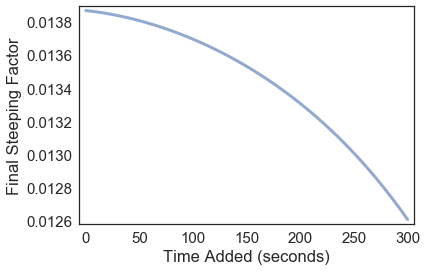

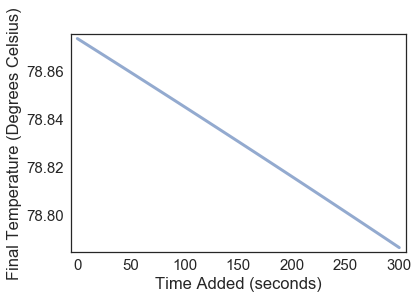

In [27]:
plot(sweep1)
decorate(xlabel='Time Added (seconds)',
         ylabel='Final Steeping Factor',
         loc='center left')
newfig()
plot(sweep2)
decorate(xlabel='Time Added (seconds)',
         ylabel='Final Temperature (Degrees Celsius)',
         loc='center left')#relative = SweepSeries()
for t in(sweep1):
    relative[t] = sweep1[t]/s_inf *100

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


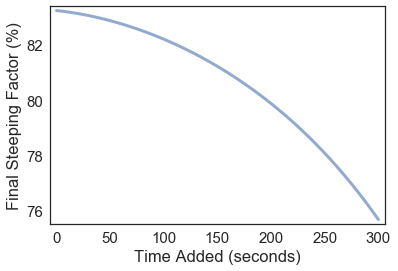

In [28]:
relative = SweepSeries()
for t in(sweep1.index):
    relative[t] = sweep1[t]/s_inf *100

plot(relative)
decorate(xlabel='Time Added (seconds)',
         ylabel='Final Steeping Factor (%)',
         loc='center left')

In [29]:
run_and_mix(t_add = 4*60, t_total=30*60)

(64.493596916290059, 0.01609185912603121)

In [58]:
def run_and_mix_2(t_add = 4*60, t_total=5*60):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    tea = make_system(T_init=90, r = r_tea, s_inf = s_inf_tea, volume=300, t_end=t_add)

    run_simulation(tea, update)

    milk = make_system(T_init=5, r = r_tea, s_inf = s_inf, volume=30, t_end=t_add)
    
    #run_simulation(milk, update)
    
    mixture = mix(tea, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return tea, mixture

In [80]:
toople = run_and_mix_2(t_total = 7*60)
tea = toople[0]
mixture = toople[1]
#mixture.results

In [81]:
series1 = Series()
series2 = Series()
for t in mixture.results.index:
    #print(mixture[t])
    series1.loc[240+t] = mixture.results.temp[t]
    series2.loc[240+t] = mixture.results.steeping[t]

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


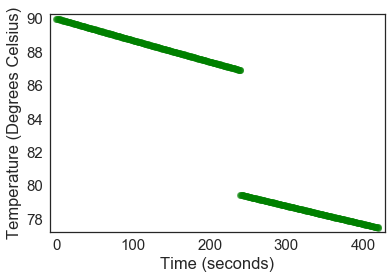

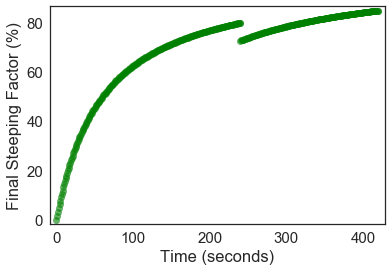

In [82]:
def plot_relative2(series):
    """Takes a series of steeping data and plots it as a percentage
    series: Series with sweep data
    """
    relative = SweepSeries()
    for t in(series.index):
        relative[t] = series[t]/s_inf *100

    plot(relative, 'go')
    decorate(xlabel='Time (seconds)',
         ylabel='Final Steeping Factor (%)',
         loc='center left')
    
plot(series1, 'go')
plot(tea.results.temp, 'go')
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (Degrees Celsius)',
         loc='center left')
newfig()
plot_relative2(series2)
plot_relative2(tea.results.steeping)


In [46]:
def shift_right(system, shift):
    """Shifts the indexes of a series up by shift
    system: system containing DataFrame with columns temp and steeping
    shift = amount to shift right
    
    returns: DataFrame with columns temp and steeping index starts at shift
    """
    
    
    state = State(temp = 90.0, steeping = 0.0)
    frame = TimeFrame(columns = state.index)
    for t in system.results.index:
        state.temp = mixture.results.temp[t]
        state.steeping = mixture.results.steeping[t]
        frame.loc[t+shift] = state
        
    
    return frame

def plot_relative(series):
    """Takes a series of steeping data and plots it as a percentage
    series: Series with sweep data
    """
    relative = SweepSeries()
    for t in(series.index):
        relative[t] = series[t]/s_inf *100

    plot(relative, 'brown')
    decorate(xlabel='Time Added (seconds)',
         ylabel='Final Steeping Factor (%)',
         loc='center left')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


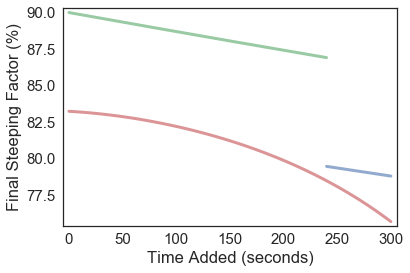

In [35]:
frame = shift_right(mixture, 240)

plot(series1)
plot(tea.results.temp)
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (Degrees Celsius)',
         loc='center left')
plot_relative(sweep1)

In [36]:
def dsouza_drip():

SyntaxError: unexpected EOF while parsing (<ipython-input-36-bdb1709185ae>, line 1)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


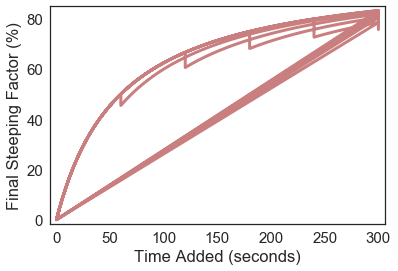

In [60]:
for i in linrange(0, 300, 60):
    toople = run_and_mix_2(t_add = i)
    tea = toople[0]
    mixture = toople[1]
    plot_relative(tea.results.steeping)
    decorate(label = str(i))
    frame = shift_right(mixture, i)
    plot_relative(frame.steeping)

In [115]:
sweep1 = SweepSeries()
sweep2 = SweepSeries()
state = State(temp=90, steeping=0)
for t_add in linrange(0, 30*60, 5):
    state = run_and_mix(t_add, t_total = 30*60)
    sweep1[t_add] = state[1]
    sweep2[t_add] = state[0]
    #print(state)

Saving figure to file final_steeping_fig.png
Saving figure to file final_temperature_fig.png


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


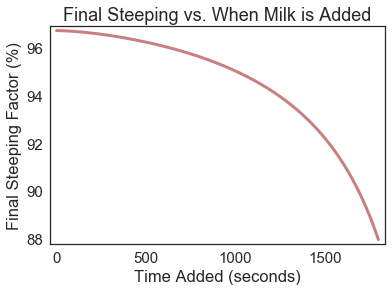

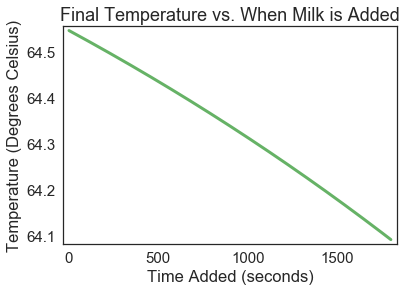

In [116]:
plot_relative(sweep1)
decorate(title = 'Final Steeping vs. When Milk is Added')
savefig('final_steeping_fig.png')
newfig()
plot(sweep2, 'g')
decorate(xlabel='Time Added (seconds)',
         ylabel='Temperature (Degrees Celsius)',
         loc='center left', title = 'Final Temperature vs. When Milk is Added')
savefig('final_temperature_fig.png')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


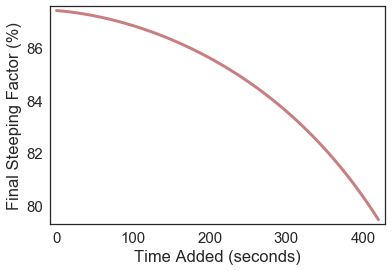

In [98]:
sweep1 = SweepSeries()
sweep2 = SweepSeries()
state = State(temp=90, steeping=0)
for t_add in linrange(0, 7*60, 5):
    state = run_and_mix(t_add, t_total = 7*60)
    sweep1[t_add] = state[1]
    sweep2[t_add] = state[0]
    #print(state)

plot_relative(sweep1)

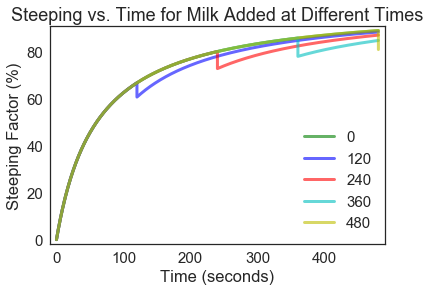

In [111]:
def plot_relative2(series, label, color):
    """Takes a series of steeping data and plots it as a percentage
    series: Series with sweep data
    """
    relative = SweepSeries()
    for t in(series.index):
        relative[t] = series[t]/s_inf *100

    plot(relative, label = label, color = color)
    decorate(xlabel='Time (seconds)',
         ylabel='Steeping Factor (%)',
         loc='center right')
newfig()
color_array = ['g', 'b', 'r', 'c', 'y', 'black', 'grey', 'purple']
for i in linrange(0, 60*8, 120):
    toople = run_and_mix_2(t_total = 60*8, t_add = i)
    tea = toople[0]
    mixture = toople[1]
    plot_relative2(tea.results.steeping, label = str(int(i)), color = color_array[int(i/120)])
    frame = shift_right(mixture, i)
    plot_relative2(frame.steeping, label = str(int(i)),color = color_array[int(i/120)])
decorate(title = 'Steeping vs. Time for Milk Added at Different Times')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


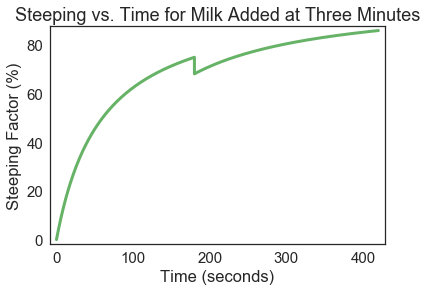

In [112]:
def plot_relative3(series, color):
    """Takes a series of steeping data and plots it as a percentage
    series: Series with sweep data
    """
    relative = SweepSeries()
    for t in(series.index):
        relative[t] = series[t]/s_inf *100

    plot(relative, color = color)
    decorate(xlabel='Time (seconds)',
         ylabel='Steeping Factor (%)',
         loc='center right')
newfig()
color_array = ['g', 'b', 'r', 'c', 'y', 'black', 'grey', 'purple']

toople = run_and_mix_2(t_total = 60*7, t_add = 3*60)
tea = toople[0]
mixture = toople[1]
plot_relative3(tea.results.steeping, color = 'g')
frame = shift_right(mixture, 3*60)
plot_relative3(frame.steeping,color = 'g')
decorate(title = 'Steeping vs. Time for Milk Added at Three Minutes')

In [125]:
run_and_mix(t_add = 30, t_total = 30*60)

(64.539103279399853, 0.016115106645977383)

In [ ]:
run_and_mix()